# 1. Buiiding CNN and Unets model from scratch

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import imgaug as ia
import imgaug.augmenters as iaa
ia.__version__

'0.4.0'

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
tf.__version__

'2.8.0'

In [4]:
import keras
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

## Prepare paths of input images and segmentation masks

In [5]:
IMG_SIZE = (320, 320)
CLASSES = ['void', 'flat', 'construction', 'object', 'nature', 
               'sky', 'human', 'vehicle']
NUM_CLASSES = 8
BATCH_SIZE = 2

In [6]:
TRAIN_INPUT_DIR="local_dataset/leftImg8bit/train"
TRAIN_MASK_DIR="local_dataset/gtFine/train"

VAL_INPUT_DIR = "local_dataset/leftImg8bit/val"
VAL_MASK_DIR = "local_dataset/gtFine/val"

TEST_INPUT_DIR = "local_dataset/leftImg8bit/test"
TEST_MASK_DIR = "local_dataset/gtFine/test"

In [7]:
def img_paths(input_dir, mask_dir):
    img_paths=[]
    mask_paths=[]
    for path, subdirs, files in os.walk(input_dir):
        for fname in files:
            if fname.endswith(".png"):
                #image paths
                img_path = os.path.join(path, fname)
                img_paths.append(img_path)
                
                
                #mask paths
                mask_path = re.sub(input_dir, mask_dir, img_path) #change path
                mask_path = re.sub("leftImg8bit.png", "gtFine_labelIds.png", mask_path) #change mask name
                #path validity check
                if os.path.isfile(mask_path):
                    mask_paths.append(mask_path)
                else:
                    print ("File not exist:", mask_path)
                
    return img_paths, mask_paths

In [8]:
train_img_paths, train_mask_paths= img_paths(TRAIN_INPUT_DIR, TRAIN_MASK_DIR)

val_img_paths,val_mask_paths = img_paths(VAL_INPUT_DIR,VAL_MASK_DIR)

test_img_paths, test_mask_paths = img_paths(TEST_INPUT_DIR,TEST_MASK_DIR)


print("Number of training samples:", len(train_img_paths))

for input_path, target_path in zip(train_img_paths[:1], train_mask_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of validation samples:", len(val_img_paths))
for input_path, target_path in zip(val_img_paths[:1], val_mask_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of test samples:", len(test_img_paths))
for input_path, test_path in zip(test_img_paths[:10], test_mask_paths[:10]):
    print(input_path, "|", test_path)

Number of training samples: 316
local_dataset/leftImg8bit/train\bremen\bremen_000000_000019_leftImg8bit.png | local_dataset/gtFine/train\bremen\bremen_000000_000019_gtFine_labelIds.png
Number of validation samples: 13
local_dataset/leftImg8bit/val\aachen\aachen_000001_000019_leftImg8bit.png | local_dataset/gtFine/val\aachen\aachen_000001_000019_gtFine_labelIds.png
Number of test samples: 1
local_dataset/leftImg8bit/test\munich\munich_000000_000019_leftImg8bit.png | local_dataset/gtFine/test\munich\munich_000000_000019_gtFine_labelIds.png


### Ramdon picture checking

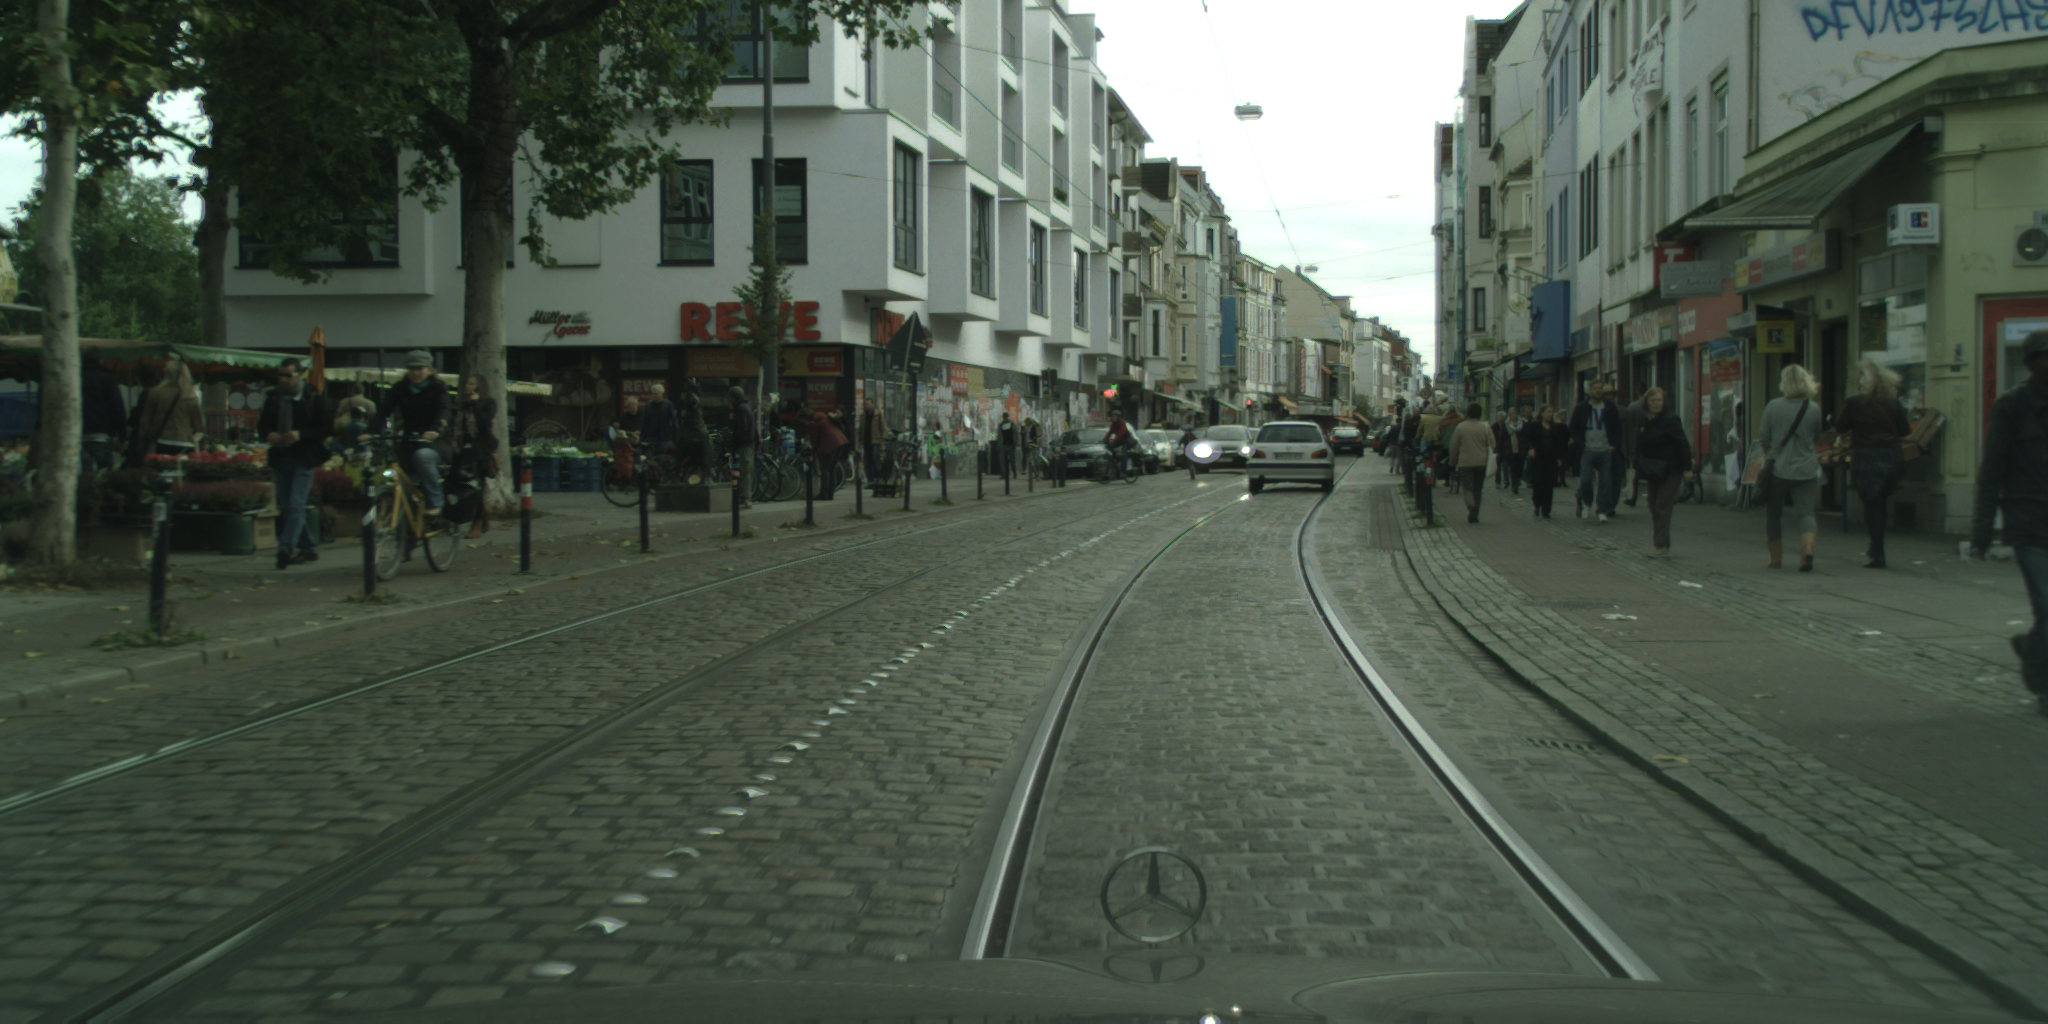

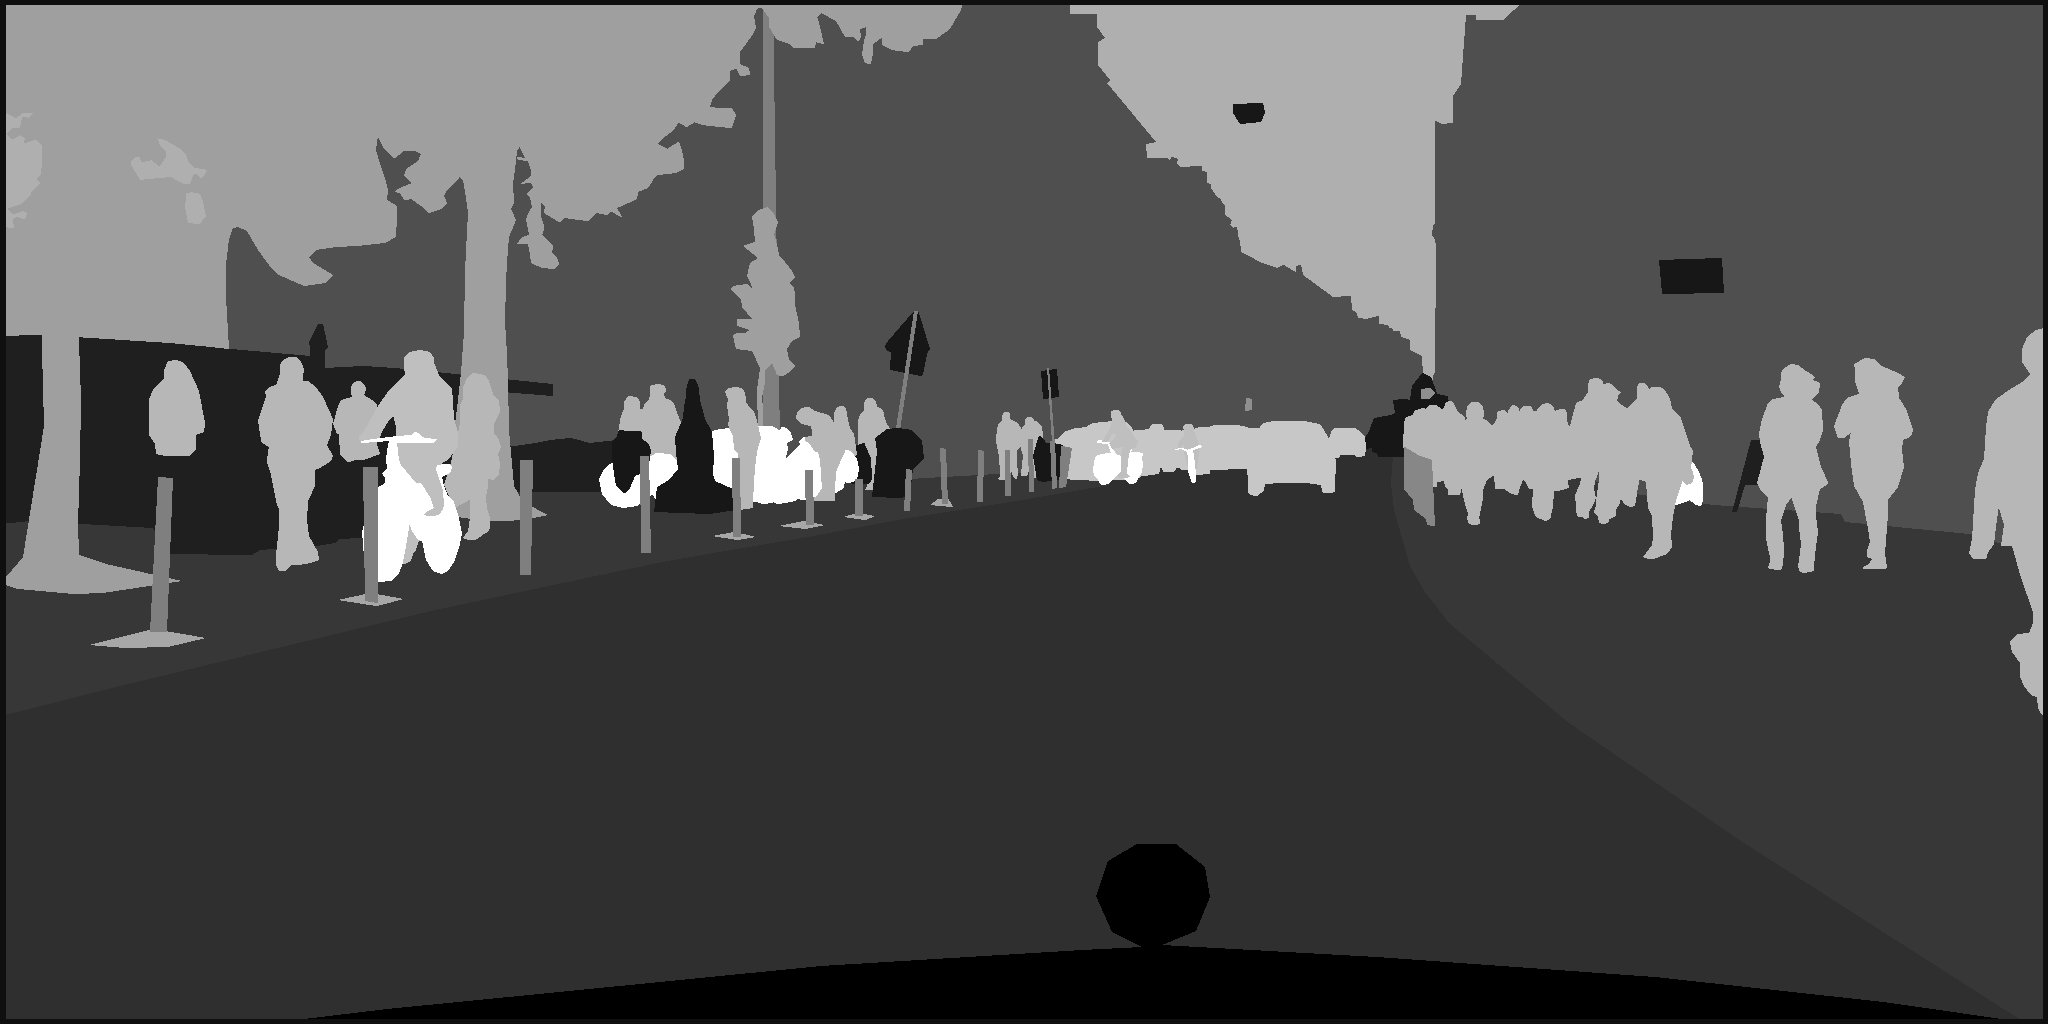

In [9]:
# Display input image #7
display(Image(filename=train_img_paths[100]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(train_mask_paths[100]))
display(img)

## Set train & validation data

### set a helper function : changing label Ids to category Ids 

In [10]:
# Mapping of ignore categories and valid ones (numbered from 1-19)
cat_mapping = { 
            0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0,  #void
            7:1, 8:1, 9:1, 10:1, #flat
            11:2, 12:2, 13:2, 14:2, 15:2, 16:2, #construction
            17:3, 18:3, 19:3, 20:3, #object
            21:4, 22:4, #nature
            23:5, #sky
            24:6, 25:6, #human
            26:7, 27:7, 28:7, 29:7, 30:7, 31:7, 32:7, 33:7, -1:7 #vehicle
            }    

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in cat_mapping:
        label_mask[mask == k] = cat_mapping[k]
    return label_mask

In [11]:
for i in range(1):
    img = load_img(train_mask_paths[i], color_mode="grayscale")
    mask=img_to_array(img)
    print("mask_org :", mask.shape)
    print('label ids:',np.unique(mask))
    
    cat = encode_labels(mask)
    print("\n mask_chg:", cat.shape)
    print('class ids:',np.unique(cat))

mask_org : (1024, 2048, 1)
label ids: [ 1.  3.  4.  7.  8. 11. 17. 20. 21. 22. 23. 26. 33.]

 mask_chg: (1024, 2048, 1)
class ids: [0. 1. 2. 3. 4. 5. 7.]


### set a data augmentation function

In [12]:
# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        iaa.Affine(rotate=(-45, 45)),
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        # execute 0 to 5 of the following (less important) augmenters per image
        iaa.SomeOf((0, 5),
            [
            #due to bad weathers
            iaa.OneOf([iaa.Add((-50, 10), per_channel=0.5), # change brightness of images 
                       iaa.AddToHueAndSaturation((-50, 50)), # change hue and saturation
                       iaa.GaussianBlur((0, 3.0)), # blur images with a sigma 
                      ]),
            iaa.OneOf([
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
            ]),
            # camera partially covered or rotated
            iaa.OneOf([
                iaa.CropAndPad(
                            percent=(-0.05, 0.1),
                            pad_mode=ia.ALL,
                            pad_cval=(0, 255)
                            ),
            ]),  # rotate by -45 to 45 degrees (affects segmaps)
            ],random_order=True
        )
    ],random_order=True
)

In [13]:
#function checking with dummy images
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
segmaps = np.random.randint(0, 10, size=(16, 64, 64, 1), dtype=np.int32)

images_aug, segmaps_aug = seq(images=images, segmentation_maps=segmaps)

### Prepare Sequence class to load & vectorize batches of data

In [14]:
class Dataloader(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, img_paths, mask_paths, augmentation=False, shuffle=True):
        '''initiation'''
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.shuffle = shuffle
        self.augmentation = augmentation
        

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.mask_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
         # Initialization
        i = idx * self.batch_size
        batch_img_paths = self.img_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]
       
        #imgaug img/seg dtype
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8") #float32  
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="int32") #uint8
        
        # Generate data
        for j, path in enumerate(batch_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        for j, path in enumerate(batch_mask_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = encode_labels(img_to_array(img)) # change to (0,7) categories
            
        #get augmentated data
        x_aug, y_aug = seq(images=x, segmentation_maps=y)
        
        if self.augmentation==True:
            return x_aug.astype('float32'), y_aug.astype('uint8')
        else:
            return x.astype('float32'), y.astype('uint8')

In [15]:
# Instantiate data Sequences for each split
train_gen = Dataloader(BATCH_SIZE, IMG_SIZE, train_img_paths, train_mask_paths)
train_aug_gen = Dataloader(BATCH_SIZE, IMG_SIZE, train_img_paths, train_mask_paths, augmentation=True)
val_gen = Dataloader(1, IMG_SIZE, val_img_paths, val_mask_paths)

## Building simple models

In [16]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

### a simple CNN model

In [17]:
def get_cnn_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=1, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(8, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    return model

# Build model
cnn_model = get_cnn_model(IMG_SIZE, NUM_CLASSES)

cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 320, 320, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 320, 320, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 16)      4624      
                                                                 
 batch_normalization_1 (Batc  (None, 320, 320, 16)     64        
 hNormalization)                                             

### Training

In [18]:
# We use the "sparse" version of categorical_crossentropy
#for pixel-wise multi-class segmentation(nclasses), where target labels are not one hot encoded. 
#One hot encoding creates memory issues if your data size and/or model is very large.
cnn_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
              metrics=[UpdatedMeanIoU(num_classes=NUM_CLASSES)]
             )

callbacks = [
    keras.callbacks.ModelCheckpoint("outputs/cnn_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

aug_callbacks = [
    keras.callbacks.ModelCheckpoint("outputs/cnn_aug_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

In [23]:
%%time
keras.backend.clear_session()
# Train the model, doing validation at the end of each epoch.
epochs = 15
cnn_history = cnn_model.fit(train_gen, 
          epochs=epochs, 
          validation_data=val_gen, 
          callbacks=callbacks,
          shuffle=True
         )

Epoch 1/15
158/158 [==============================] - 108s 685ms/step - loss: 0.9339 - updated_mean_io_u: 0.3477 - val_loss: 0.8761 - val_updated_mean_io_u: 0.3446
Epoch 2/15
158/158 [==============================] - 104s 662ms/step - loss: 0.8676 - updated_mean_io_u: 0.3726 - val_loss: 0.9198 - val_updated_mean_io_u: 0.3363
Epoch 3/15
158/158 [==============================] - 103s 656ms/step - loss: 0.8425 - updated_mean_io_u: 0.3817 - val_loss: 0.8926 - val_updated_mean_io_u: 0.3661
Epoch 4/15
158/158 [==============================] - 96s 600ms/step - loss: 0.8304 - updated_mean_io_u: 0.3844 - val_loss: 1.2746 - val_updated_mean_io_u: 0.2974
CPU times: total: 7min 58s
Wall time: 6min 54s


In [24]:
print('best val_iou_score :', max(cnn_history.history['val_updated_mean_io_u']))

best val_iou_score : 0.36610841751098633


### CNN model with augmentation

In [19]:
%%time
keras.backend.clear_session()
# Train the model, doing validation at the end of each epoch.
epochs = 15
cnn_aug_history = cnn_model.fit(train_aug_gen, 
          epochs=epochs, 
          validation_data=val_gen, 
          callbacks=aug_callbacks,
          shuffle=True
         )

Epoch 1/15
158/158 [==============================] - 120s 620ms/step - loss: 1.3864 - updated_mean_io_u: 0.2110 - val_loss: 1.7391 - val_updated_mean_io_u: 0.1078
Epoch 2/15
158/158 [==============================] - 91s 580ms/step - loss: 1.2130 - updated_mean_io_u: 0.2511 - val_loss: 1.1995 - val_updated_mean_io_u: 0.2476
Epoch 3/15
158/158 [==============================] - 92s 587ms/step - loss: 1.1769 - updated_mean_io_u: 0.2630 - val_loss: 1.2511 - val_updated_mean_io_u: 0.2340
Epoch 4/15
158/158 [==============================] - 93s 587ms/step - loss: 1.1620 - updated_mean_io_u: 0.2663 - val_loss: 1.1558 - val_updated_mean_io_u: 0.2516
Epoch 5/15
158/158 [==============================] - 76s 484ms/step - loss: 1.1375 - updated_mean_io_u: 0.2798 - val_loss: 1.3721 - val_updated_mean_io_u: 0.1943
Epoch 6/15
158/158 [==============================] - 33s 210ms/step - loss: 1.1394 - updated_mean_io_u: 0.2825 - val_loss: 1.1468 - val_updated_mean_io_u: 0.2299
Epoch 7/15
158/158 [=

In [21]:
print('best val_iou_score :', max(cnn_aug_history.history['val_updated_mean_io_u']))

best val_iou_score : 0.318743497133255


### visualise a prediction

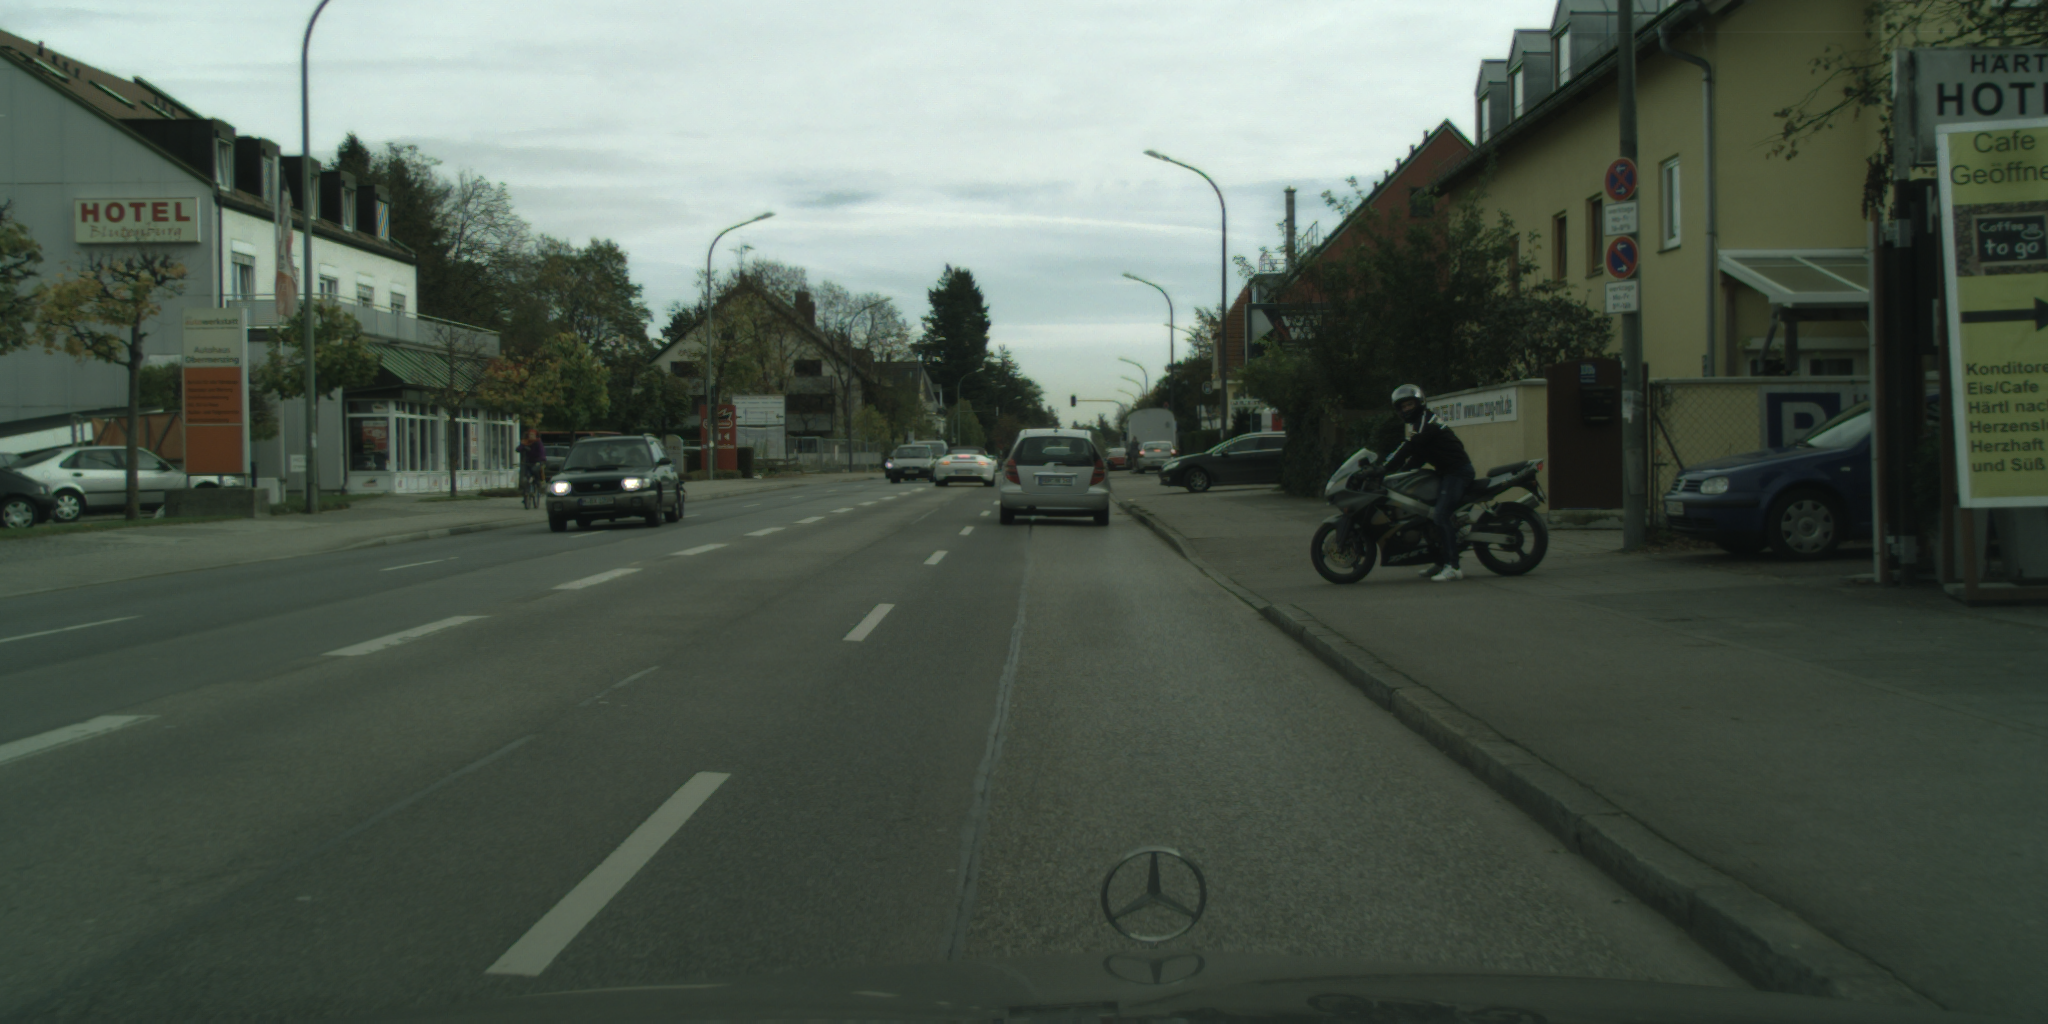

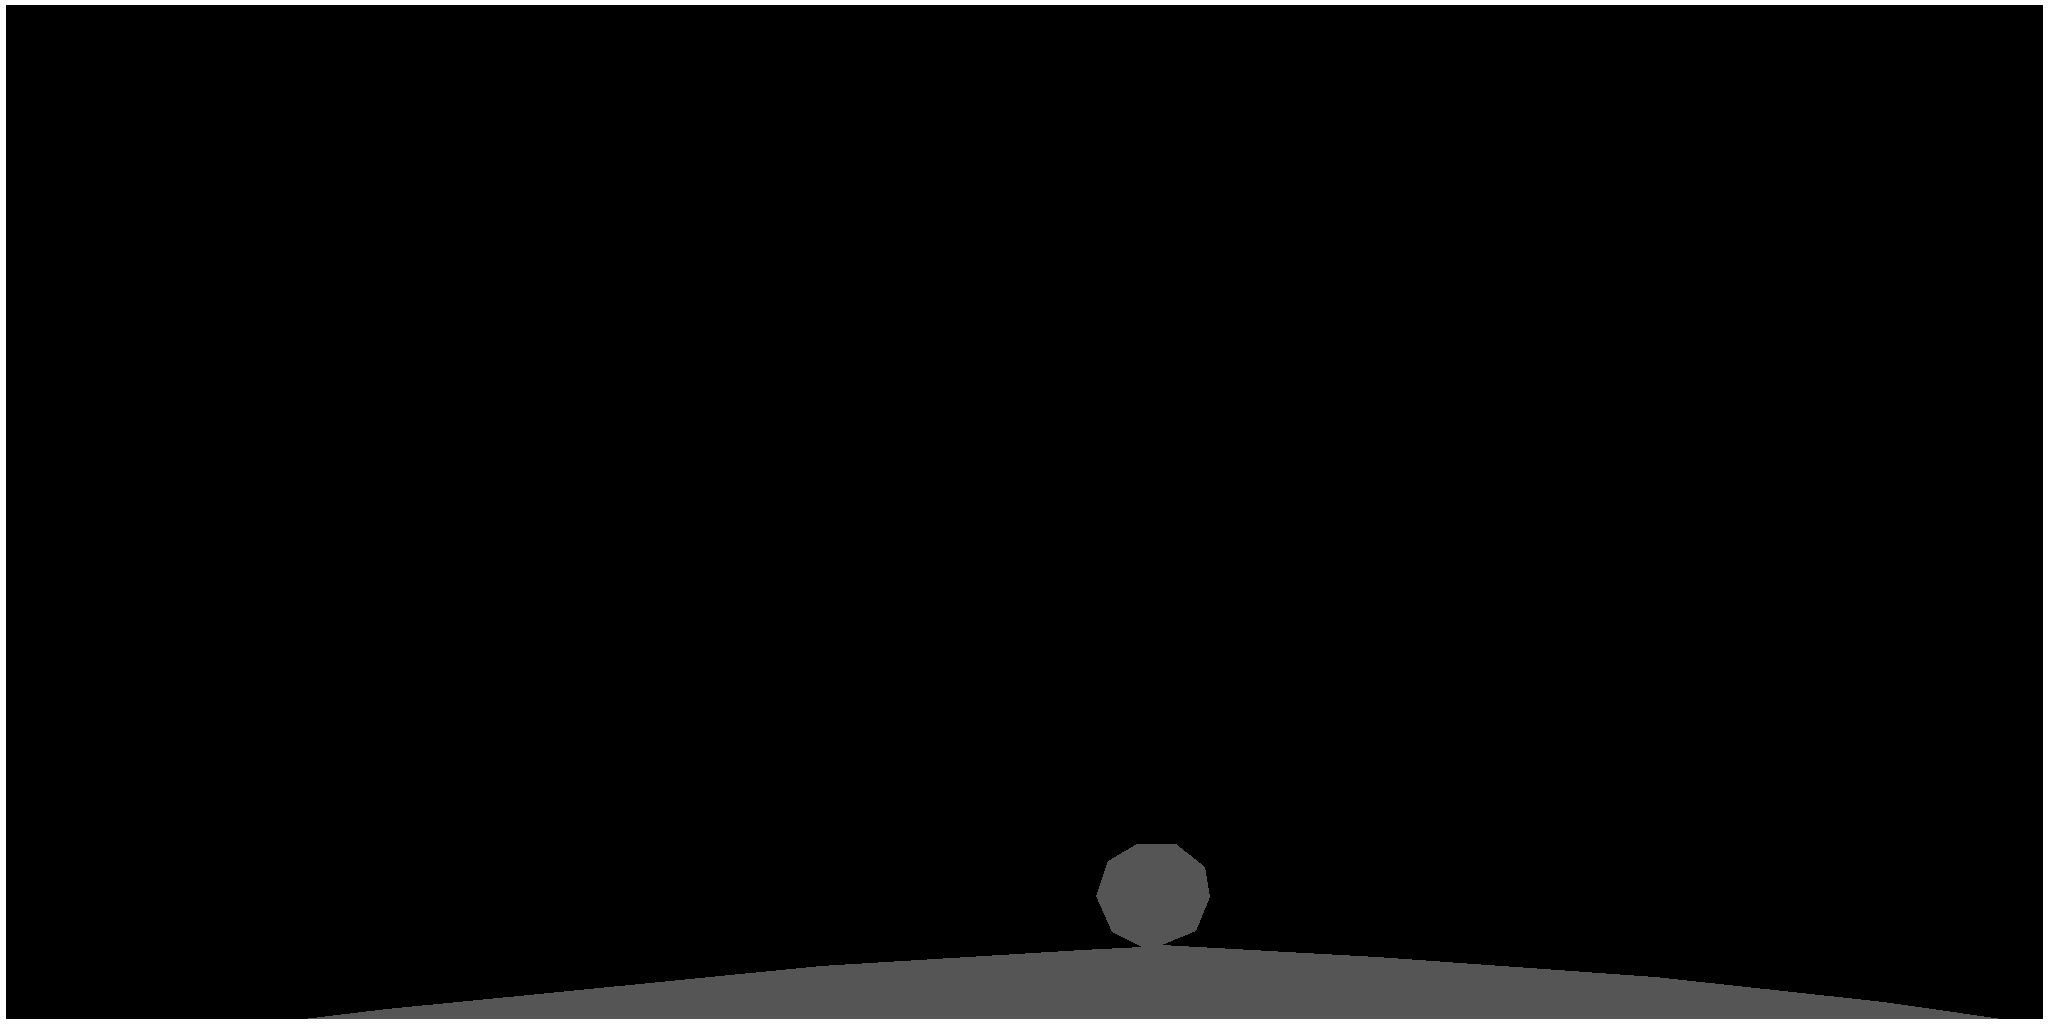

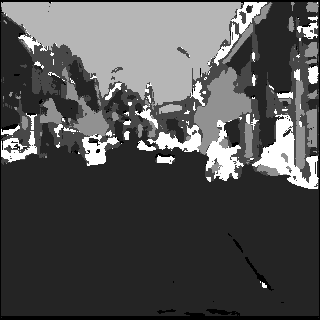

In [25]:
test_gen = Dataloader(1, IMG_SIZE, test_img_paths, test_mask_paths)
test_preds = cnn_model.predict(test_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #1
i = 0

# Display input image
display(Image(filename=test_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_mask_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 480x960.

## Buiding a ResNet model

In [17]:
def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

# Build model
unet_model = get_unet_model(IMG_SIZE, NUM_CLASSES)

unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 add_2 (Add)                    (None, 20, 20, 256)  0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_3[0][0]']               
                                                                                                  
 activation_7 (Activation)      (None, 20, 20, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 20, 20, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 20, 20, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
          

                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 160, 160, 32  18464      ['activation_13[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 160, 160, 32  128        ['conv2d_transpose_6[0][0]']     
 ormalization)                  )                                                                 
                                                                                                  
 activation_14 (Activation)     (None, 160, 160, 32  0           ['batch_normalization_13[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_tr

In [18]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
#for pixel-wise multi-class segmentation(nclasses), where target labels are not one hot encoded. 
#One hot encoding creates memory issues if your data size and/or model is very large.
unet_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
              metrics=[UpdatedMeanIoU(num_classes=NUM_CLASSES)]
             )

callbacks = [
    keras.callbacks.ModelCheckpoint("outputs/Unet_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

aug_callbacks = [
    keras.callbacks.ModelCheckpoint("outputs/Unet_aug_model.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

### Training with the original dataset

In [19]:
%%time
keras.backend.clear_session()
# Train the model, doing validation at the end of each epoch.
epochs = 15
unet_history = unet_model.fit(train_gen, 
          epochs=epochs, 
          validation_data=val_gen, 
          callbacks=callbacks,
          shuffle=True
         )

Epoch 1/15
158/158 [==============================] - 45s 226ms/step - loss: 1.6769 - updated_mean_io_u: 0.3192 - val_loss: 1.5093 - val_updated_mean_io_u: 0.1660
Epoch 2/15
158/158 [==============================] - 33s 209ms/step - loss: 0.7929 - updated_mean_io_u: 0.4079 - val_loss: 2.0527 - val_updated_mean_io_u: 0.1012
Epoch 3/15
158/158 [==============================] - 33s 210ms/step - loss: 0.6739 - updated_mean_io_u: 0.4546 - val_loss: 0.8430 - val_updated_mean_io_u: 0.4055
Epoch 4/15
158/158 [==============================] - 33s 208ms/step - loss: 0.6149 - updated_mean_io_u: 0.4793 - val_loss: 0.9195 - val_updated_mean_io_u: 0.3447
Epoch 5/15
158/158 [==============================] - 35s 219ms/step - loss: 0.5605 - updated_mean_io_u: 0.5074 - val_loss: 0.9230 - val_updated_mean_io_u: 0.3892
Epoch 6/15
158/158 [==============================] - 41s 259ms/step - loss: 0.5248 - updated_mean_io_u: 0.5180 - val_loss: 0.7452 - val_updated_mean_io_u: 0.4430
Epoch 7/15
158/158 [==

In [20]:
print('best val_iou_score :', max(unet_history.history['val_updated_mean_io_u']))

best val_iou_score : 0.5036225318908691


### Training using augmentated data

In [21]:
%%time
keras.backend.clear_session()
# Train the model, doing validation at the end of each epoch.
epochs = 15
unet_aug_history = unet_model.fit(train_aug_gen, 
          epochs=epochs, 
          validation_data=val_gen, 
          callbacks=aug_callbacks,
          shuffle=True
         )

Epoch 1/15
158/158 [==============================] - 43s 264ms/step - loss: 0.8696 - updated_mean_io_u: 0.3810 - val_loss: 1.2581 - val_updated_mean_io_u: 0.2726
Epoch 2/15
158/158 [==============================] - 41s 258ms/step - loss: 0.7295 - updated_mean_io_u: 0.4217 - val_loss: 1.2966 - val_updated_mean_io_u: 0.2678
Epoch 3/15
158/158 [==============================] - 41s 260ms/step - loss: 0.7156 - updated_mean_io_u: 0.4286 - val_loss: 0.6935 - val_updated_mean_io_u: 0.4211
Epoch 4/15
158/158 [==============================] - 41s 259ms/step - loss: 0.6834 - updated_mean_io_u: 0.4408 - val_loss: 0.6425 - val_updated_mean_io_u: 0.4245
Epoch 5/15
158/158 [==============================] - 41s 259ms/step - loss: 0.6571 - updated_mean_io_u: 0.4519 - val_loss: 0.6942 - val_updated_mean_io_u: 0.4200
Epoch 6/15
158/158 [==============================] - 41s 261ms/step - loss: 0.6377 - updated_mean_io_u: 0.4580 - val_loss: 0.5440 - val_updated_mean_io_u: 0.4705
Epoch 7/15
158/158 [==

In [22]:
print('best val_iou_score :', max(unet_aug_history.history['val_updated_mean_io_u']))

best val_iou_score : 0.4705039858818054


### Visualize a prediction

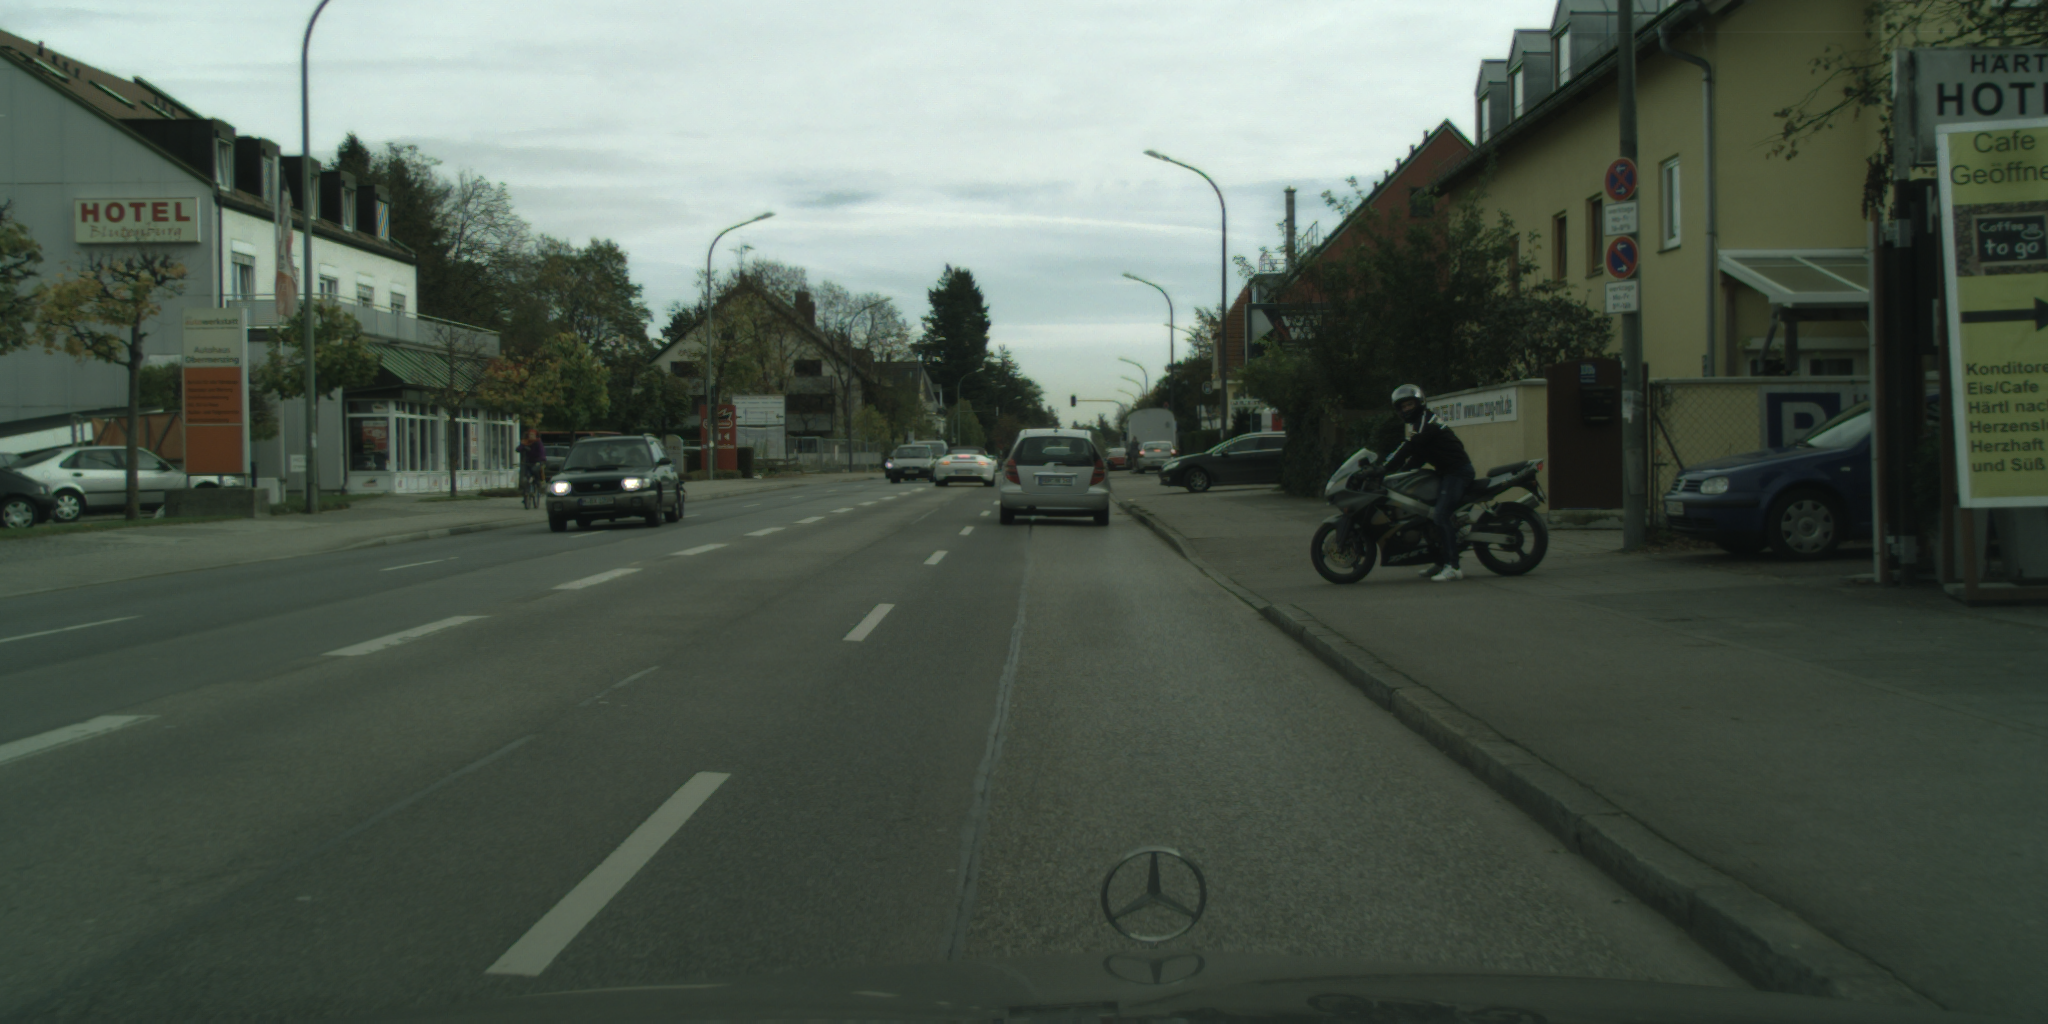

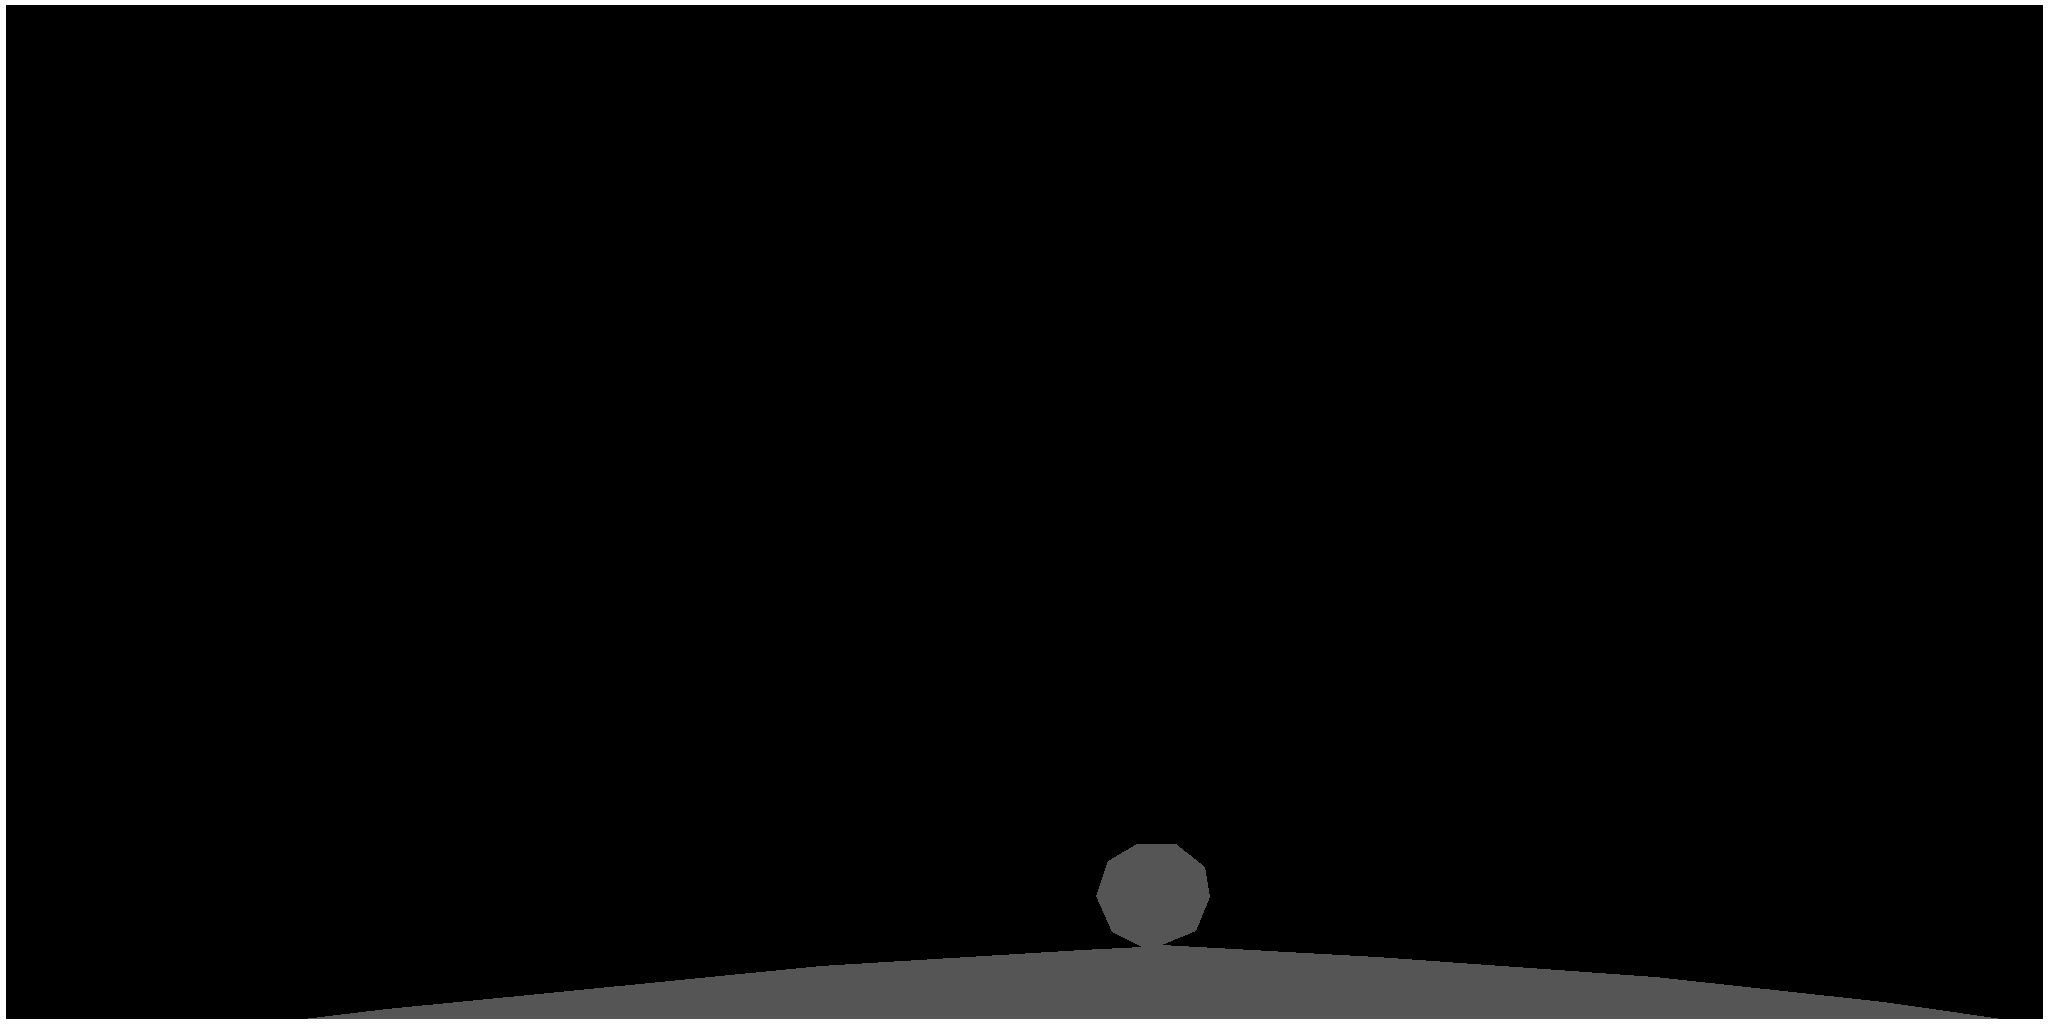

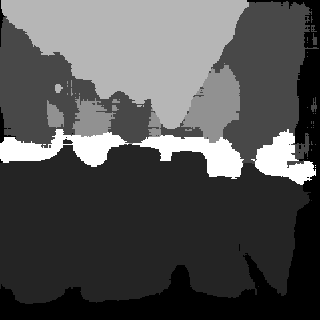

In [23]:
test_gen = Dataloader(1, IMG_SIZE, test_img_paths, test_mask_paths)
test_preds = unet_model.predict(test_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #1
i = 0

# Display input image
display(Image(filename=test_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_mask_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 480x960.